In [ ]:
Use Autoencoder to implement anomaly detection. Build the model by using: 
a. Import required libraries b. Upload / access the dataset 
c. Encoder converts it into latent representation 
d. Decoder networks convert it back to the original input 
e. Compile the models with Optimizer, Loss, and Evaluation Metrics

In [1]:
#importing libraries and dataset
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import MeanSquaredLogarithmicError

PATH_TO_DATA = 'http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv'
data = pd.read_csv(PATH_TO_DATA, header=None)
data.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


In [2]:
#finding shape of the dataset
data.shape

(4998, 141)

In [3]:
#splitting training and testing dataset
features = data.drop(140, axis=1)
target = data[140]
x_train, x_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, stratify=target
)
train_index = y_train[y_train == 1].index
train_data = x_train.loc[train_index]

In [4]:
#scaling the data using MinMaxScaler
min_max_scaler = MinMaxScaler(feature_range=(0, 1))
x_train_scaled = min_max_scaler.fit_transform(train_data.copy())
x_test_scaled = min_max_scaler.transform(x_test.copy())

In [5]:
#creating autoencoder subclass by extending Model class from keras
class AutoEncoder(Model):
  def __init__(self, output_units, ldim=8):
    super().__init__()
    self.encoder = Sequential([
      Dense(64, activation='relu'),
      Dropout(0.1),
      Dense(32, activation='relu'),
      Dropout(0.1),
      Dense(16, activation='relu'),
      Dropout(0.1),
      Dense(ldim, activation='relu')
    ])
    self.decoder = Sequential([
      Dense(16, activation='relu'),
      Dropout(0.1),
      Dense(32, activation='relu'),
      Dropout(0.1),
      Dense(64, activation='relu'),
      Dropout(0.1),
      Dense(output_units, activation='sigmoid')
    ])
  
  def call(self, inputs):
    encoded = self.encoder(inputs)
    decoded = self.decoder(encoded)
    return decoded

In [6]:
#model configuration
model = AutoEncoder(output_units=x_train_scaled.shape[1])
model.compile(loss='msle', metrics=['mse'], optimizer='adam')
epochs = 20

history = model.fit(
    x_train_scaled,
    x_train_scaled,
    epochs=epochs,
    batch_size=512,
    validation_data=(x_test_scaled, x_test_scaled)
)

Epoch 1/20
5/5 [==============================] - 1s 45ms/step - loss: 0.0106 - mse: 0.0241 - val_loss: 0.0132 - val_mse: 0.0309
Epoch 2/20
5/5 [==============================] - 0s 12ms/step - loss: 0.0102 - mse: 0.0231 - val_loss: 0.0128 - val_mse: 0.0301
Epoch 3/20
5/5 [==============================] - 0s 10ms/step - loss: 0.0094 - mse: 0.0213 - val_loss: 0.0124 - val_mse: 0.0292
Epoch 4/20
5/5 [==============================] - 0s 10ms/step - loss: 0.0085 - mse: 0.0191 - val_loss: 0.0123 - val_mse: 0.0288
Epoch 5/20
5/5 [==============================] - 0s 11ms/step - loss: 0.0075 - mse: 0.0170 - val_loss: 0.0119 - val_mse: 0.0278
Epoch 6/20
5/5 [==============================] - 0s 10ms/step - loss: 0.0068 - mse: 0.0153 - val_loss: 0.0116 - val_mse: 0.0272
Epoch 7/20
5/5 [==============================] - 0s 11ms/step - loss: 0.0062 - mse: 0.0140 - val_loss: 0.0115 - val_mse: 0.0269
Epoch 8/20
5/5 [==============================] - 0s 10ms/step - loss: 0.0058 - mse: 0.0131 - val

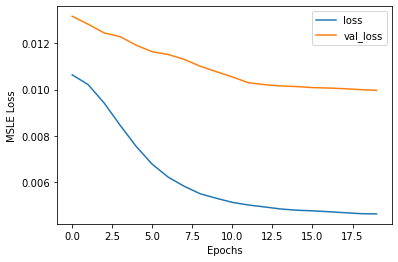

In [7]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('MSLE Loss')
plt.legend(['loss', 'val_loss'])
plt.show()

In [8]:
#finding threshold for anomaly and doing predictions
def find_threshold(model, x_train_scaled):
  reconstructions = model.predict(x_train_scaled)
  reconstruction_errors = tf.keras.losses.msle(reconstructions, x_train_scaled)
  threshold = np.mean(reconstruction_errors.numpy()) \
   + np.std(reconstruction_errors.numpy())
  return threshold

def get_predictions(model, x_test_scaled, threshold):
  predictions = model.predict(x_test_scaled)
  errors = tf.keras.losses.msle(predictions, x_test_scaled)
  anomaly_mask = pd.Series(errors) > threshold
  preds = anomaly_mask.map(lambda x: 0.0 if x == True else 1.0)
  return preds

threshold = find_threshold(model, x_train_scaled)
print(f"Threshold: {threshold}")

73/73 [==============================] - 0s 708us/step
Threshold: 0.010027644901653487


In [9]:
#getting accuracy score
predictions = get_predictions(model, x_test_scaled, threshold)
accuracy_score(predictions, y_test)

32/32 [==============================] - 0s 968us/step


0.948